In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diplom/cleaned.pkl
/kaggle/input/diplom/dp_wild_reviews.csv
/kaggle/input/diplom/dp_women-clothing-accessories.3-class.balanced.csv
/kaggle/input/diplom/cleaned_to_pred.pkl


План выполнения работы:
1. [EDA датасета для обучения и оценки модели и датасета для inference](https://colab.research.google.com/drive/1l45ZPxSMYo8rCczzkARkGWI0NQN1vvFc?usp=sharing)

2. Тематическое моделирование датасета для обучения и оценки модели

3. Выбор модели для классификации отзывов на товары:
  
  * Baseline - LogisticRegression
  * cnn_rand
  * cnn_static
  * cnn_non_static
  * Реккурентная bi-LSTM 
  * предобученная модель rubert с huggingface
  
4. Inference на тестовом датасете

5. Генерация ответов на отрицательные отзывы


#0. Загрузка модулей, импорт библиотек и пользовательские функции

In [ ]:
!pip install compress-fasttext

In [ ]:
import compress_fasttext

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from copy import deepcopy

In [5]:
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import nltk

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path_to_save = '/kaggle/working/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'

In [ ]:
stopwords = stopwords.words("russian")
stopwords.extend(['очень', 'такой', 'какой'])
stopwords.remove('не')
stopwords.remove('ни')
stopwords.remove('никогда')

In [ ]:
# Укажите URL для загрузки и путь для сохранения файла
url = 'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-400K-100K-300.bin'

# Загрузить файл с помощью wget
!wget -O geowac_tokens_sg_300_5_2020-400K-100K-300.bin {url}



In [ ]:
# Переместить файл в нужное местоположение
shutil.move('geowac_tokens_sg_300_5_2020-400K-100K-300.bin', path_to_save)

In [ ]:
# Проверить, что файл сохранен
if os.path.exists(path_to_save):
    print("Файл успешно сохранен по указанному пути:", path_to_save)
else:
    print("Ошибка при сохранении файла.")

In [ ]:
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(path_to_save) # не нужно, это эмбеддинги для отдельных слов, а нам нужно для предложения

In [7]:
! pip install transformers

In [ ]:
!pip install -U pip setuptools wheel

In [ ]:
! pip install -U spacy

In [ ]:
! python -m spacy download ru_core_news_sm

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("ru_core_news_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

In [8]:
from transformers import AutoTokenizer, AutoModel

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


In [ ]:
! pip install pymorphy2

In [ ]:
! pip install pymorphy2-dicts

In [ ]:
! pip install DAWG-Python

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize_text(text, method):
    """Лемматизация текста"""
    doc = nlp(text)
    words =[token.text for token in doc]
    if method=='spacy':
        lemmatized_words = [token.lemma_ for token in doc]
    elif method=='pymorphy':
        lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [ ]:
def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords
                  ])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = word_tokenize(s)
    # удаление стоп-слов - в CountVectorizer, т.к SentenceTransformer учитывает полный контекст при создании эмбеддинга
    tokens = [lemmatize_text(token, 'pymorphy') for token in tokens if len(token.strip())>1]
    # tokens = [token for token in tokens if token not in english_stopwords and len(token.strip())>1]
    s = ' '.join(tokens)
    return s

In [10]:
def tokenize(texts: list[str]) -> tuple[list[list[str]], dict, int]:
    """Токенизация текста, создание словаря, поиск максимальной длины последовательности токенов.

    Args:
        texts (List[str]): список текстов

    Returns:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Добавляем токены <pad> and <unk> к словарю
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Создаем словарь из корпуса, начиная с индекса 2
    idx = 2
    for sent in tqdm(texts):
        tokenized_sent = word_tokenize(sent)

        # Добавляем токенизированное предложение к списку ( тексту)
        tokenized_texts.append(tokenized_sent)

        # Добавляем новы токен к словарю `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # ВЫчисляем новое значение `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

In [11]:
def encode(tokenized_texts, word2idx, max_len) -> np.array(int):
    """Добавляем в каждое предложение токены <PAD> до достижения длины max_length,
    кодируем токены их индексом в словаре.

    Args:
        tokenized_texts (List[List[str]]): Список списков токенов
        word2idx (Dict): Словарь построенный из корпуса текста
        max_len (int): максимальная длина последовательности токенов
    Returns:
        input_ids (np.array): Массив индексов токенов размерностью (N, max_len).
        Будет подаваться на вход модели"""

    input_ids = []
    for tokenized_sent in tqdm(tokenized_texts):
        # Паддинг предложения до max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Кодироване токенов индексами input_ids из словаря word2idx
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)

    return np.array(input_ids)

In [12]:
def data_loader(train_inputs: np.array, val_inputs: np.array,
                train_labels: np.array, val_labels: np.array,
                batch_size: int) -> tuple[DataLoader, DataLoader]:
    """Преобразование обучающей и оценочной выборок в to torch.Tensors и загрузка в
    DataLoader.
    """

    # Преобразование в torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Создание DataLoader для train
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Создание DataLoader для val
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [13]:
import pickle
with open('/kaggle/input/diplom/cleaned.pkl', 'rb') as f:
    (texts, labels) = pickle.load(f)

In [ ]:
len(texts)

In [14]:
cleaned_texts, cleaned_labels = [], []
for i in tqdm(range(len(texts))):
    if not re.match(r'^[^а-яА-Я]*$', texts[i]):
        cleaned_texts.append(texts[i])
        cleaned_labels.append(labels[i])

  0%|          | 0/90000 [00:00<?, ?it/s]

In [ ]:
len(cleaned_texts)

In [ ]:
with open('/kaggle/input/diplom/cleaned_to_pred.pkl', 'rb') as f:
    (texts_to_pred, labels_to_pred) = pickle.load(f)

# 4. Работа с моделями классификации отзывов по тональности

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    cleaned_texts, cleaned_labels, test_size=0.2, random_state=42, stratify=cleaned_labels)

In [ ]:
# для статистических моделей вроде не нужно выделять отдельно test и val.
# Это сделано, чтобы можно было далее сравнивать с нейросетями, которые обучались на train и оценивались на Val
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
len(X_test)

In [ ]:
pickle.dump((X_train,y_train, X_val,y_val, X_test, y_test), open('/kaggle/working/split.pickle', 'wb'))

## BaseLine: TFIDF

In [ ]:
X_train_preprocessed = np.array(X_train)
X_val_preprocessed = np.array(X_val)
X_test_preprocessed = np.array(X_test)

In [ ]:
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

In [ ]:
lr_model = LogisticRegression(solver='saga',penalty='l1', max_iter=300, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

In [ ]:
train_logits = lr_model.predict_proba(X_train_tfidf)
val_logits = lr_model.predict_proba(X_val_tfidf)
test_logits = lr_model.predict_proba(X_test_tfidf)

In [ ]:
y_pred = lr_model.predict(X_val_tfidf)

In [ ]:
print(classification_report(y_pred, y_val, target_names =['negative', 'neautral', 'positive']))

In [ ]:
cm = confusion_matrix(y_val, np.array(y_pred), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
disp.plot()
plt.show()

In [ ]:
test_data=pd.DataFrame([X_test,y_test]).transpose()
test_data.columns=['review', 'sentiment']
test_data.head()

In [ ]:
test_data1=pd.DataFrame([X_test,y_test]).transpose()
test_data1.columns=['review', 'sentiment']
test_data1.head()

In [ ]:
pickle.dump((X_train_tfidf, X_val_tfidf, X_test_tfidf), open('/kaggle/working/tfidf.pickle', 'wb'))
pickle.dump(tf_idf, open('/kaggle/working/tfidf_vect.pickle', 'wb'))

In [ ]:
is_correct = []
predictions = []

for text, label in zip(X_test_tfidf, y_test):
    y_pred = lr_model.predict(text)
    is_correct.append(y_pred==label)
    predictions.append(y_pred)

# Столбец содержит признак совпадения/несовпадения факта и прогноза
test_data['lr'] = is_correct
test_data1['lr'] = predictions
print(classification_report(np.array(predictions),y_test, target_names=['negative', 'neutral', 'positive']))
cm = confusion_matrix(y_test, np.array(predictions), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
disp.plot()
plt.show()

In [ ]:
test_data.to_csv('/kaggle/working/test_data.csv', index=False)
test_data1.to_csv('/kaggle/working/test_data1.csv', index=False)

In [ ]:
# save the model to disk
filename = '/kaggle/working/lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

## Модель CNN_NLP на базе сверточных слоев

### Разбиваем на train и val, загружаем в PyTorch DataLoader

In [ ]:
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(cleaned_texts)

In [ ]:
input_ids = encode(tokenized_texts, word2idx, max_len)

In [ ]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, cleaned_labels, test_size=0.2, random_state=42, stratify = cleaned_labels)

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42, stratify = train_labels)

In [ ]:
len(train_labels), len(val_labels), len(test_labels)

In [ ]:
tr,tt,vl, t = [], [], [], []
for input in train_inputs:
  t=[]
  for el in input:
    if el !=0:
      t.append(el)
  tr.append(t)
for input in test_inputs:
  t=[]
  for el in input:
    if el !=0:
      t.append(el)
  tt.append(t)
for input in train_inputs:
  t=[]
  for el in input:
    if el !=0:
      t.append(el)
  vl.append(t)

In [ ]:
seq_len_train = [len(i) for i in tr]
seq_len_test = [len(i) for i in tt]
seq_len_val = [len(i) for i in vl]
max_seq_len = max(max(seq_len_test), max(seq_len_train), max(seq_len_val))
max_seq_len

In [ ]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]
batch_size = 50
num_classes = 3

In [ ]:
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=batch_size)

### Конструктор

In [ ]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim).Optional
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 3
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding Слой , куда подаютсяя эмбеддинги; они инициализируются случайным образом или загружаются уже предобученные
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Сверточные слои
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Полносвязный слой и Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Конкатенация x_pool_list для заполнения полносвязного слоя.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Вычисление логитов Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

### Инициализация модели

In [ ]:
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)

    cnn_model.to(device)
#     optimizer = optim.AdamW(cnn_model.parameters(),
#                                lr=learning_rate)
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### Обучение и оценка модели

#### Вспомогательные функции

In [ ]:
def load_pretrained_vectors(word2idx, ft_model):
    """Load pretrained vectors and create embedding layers.

    Args:
        word2idx (Dict): словарь из корпуса текстов
        ft_model (CompressedFastTextKeyedVectors): Compressed FastText model

    Returns:
        embeddings (np.array): матрица мбеддингов размером (N, d),
        где N -размер словаря word2idx,  d - размерность эмбеддинга
    """

    print("Loading pretrained vectors...")

    # Инициализация эмбеддингов случайными числами
    d = ft_model.vector_size
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Загрузка предобученных векторов
    count = 0
    for word in tqdm(word2idx.keys()):
        if word in ft_model:
            count += 1
            embeddings[word2idx[word]] = ft_model[word]

    print(f"Найдено {count} / {len(word2idx)} предобученных векторов.")

    return embeddings

In [38]:
# задаем функцию потерь
loss_fn = nn.CrossEntropyLoss()

In [39]:
def set_seed(seed_value=42):
    """Устанавливаем seed для генератора псевдослучайных числе."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:

            val_loss, val_accuracy = evaluate(model, val_dataloader)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': deepcopy(model.state_dict()),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, '/kaggle/working/best_model.pt')                

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Best accuracy: {best_accuracy:.2f}%.")

In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### Вариант 1: Случайная инициализация векторов слов

При повторных запусках результаты немного различаются

In [ ]:
# CNN-rand
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.1,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)
# Путь к исходному файлу
source_file = '/kaggle/working/best_model.pt'

# Целевой путь с новым именем файла
target_file = '/kaggle/working/cnn_rand.pt'

# Переименование файла
os.rename(source_file, target_file)

#### Вариант 2 - Используются compressed fastText эмбеддинги, которые замораживаются на период обучения

In [ ]:
embeddings = load_pretrained_vectors(word2idx, ft)
embeddings = torch.tensor(embeddings)

In [ ]:
# CNN-static
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)
# Путь к исходному файлу
source_file = '/kaggle/working/best_model.pt'

# Целевой путь с новым именем файла
target_file = '/kaggle/working/cnn_static.pt'

# Переименование файла
os.rename(source_file, target_file)

Результат чуть-чуть лучше и достигается быстрее - меньше чем за 110 с

#### Вариант 3: Тонкая настройка compressed fastText эмбеддингов в процессе обучения модели

In [ ]:
# CNN-non-static
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.1,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)
# Путь к исходному файлу
source_file = '/kaggle/working/best_model.pt'

# Целевой путь с новым именем файла
target_file = '/kaggle/working/cnn_non_static.pt'

# Переименование файла
os.rename(source_file, target_file)

Модель работает дольше, чем в предыдущих случаях, из-за того, что эмбеддинги разморожены и также обучаются. Но и результат - лучший из всех. Переобучение начинается с 9 эпохи

#### Вариант 4 - реккурентная сеть

In [ ]:
vocab_size = len(word2idx) + 1 # +1 for zero padding + our word tokens
output_size = 3
embedding_dim = 300

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.5
        n_classes = output_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embeddings, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):

        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
n_epochs = 30
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.to(device)
best_accuracy = 0
train_loss = []
valid_loss = []

for epoch in tqdm(range(n_epochs)):
    start_time = time.time()
    # train loop
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        # Predict/Forward Pass
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_dataloader)

    # evaluation loop
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(val_inputs),3))

    for i, (x_batch, y_batch) in enumerate(val_dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(val_dataloader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==val_labels)/len(val_labels)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': deepcopy(model.state_dict()),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, '/kaggle/working/best_model.pt')
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))
print('best accuracy =', best_accuracy)

In [ ]:
# Путь к исходному файлу
source_file = '/kaggle/working/best_model.pt'

# Целевой путь с новым именем файла
target_file = '/kaggle/working/rnn.pt'

# Переименование файла
os.rename(source_file, target_file)

#### Вариант 5: используются эмбеддинги, полученные из модели sberbank-ai/ruElectra-small

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
# Здесь короткие эмбеддинги 256
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruElectra-small")
model = AutoModel.from_pretrained("sberbank-ai/ruElectra-small")

In [ ]:
def get_emb(tt, i, batch_size, size):
    """Генерирует Усредненные эмбеддинги из текста отзывов. Обрабатывает батчами, потому что иначе памяти не хватает"""
    e_i = tokenizer(tt[batch_size*i:batch_size*(i+1)], padding=True, truncation=True, max_length=size, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**e_i)
    sentence_embeddings = mean_pooling(model_output, e_i['attention_mask'])
    with open(f"/kaggle/working/sber_embeddings_{i}.pkl", "wb") as fOut:
        pickle.dump({"embeddings": sentence_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
batch_size=300  # для длины 64 batch_size=5000, ДЛЯ 155 - 3000, ДЛЯ 300 - 300
size=300
for i in tqdm(range(len(cleaned_texts)//batch_size +1)):
    get_emb(cleaned_texts,i,batch_size, 300)

In [ ]:
def get_all_emb(size, batch_size):
    """ Возвращает список эмбеддингов всех отзывов из датасета"""
    sentence_embeddings = []
    for i in tqdm(range(len(cleaned_texts)//batch_size +1)):
        # Load sentences & embeddings from disc
        with open(f"/kaggle/working/sber_embeddings_{i}.pkl", "rb") as fIn:
            stored_data = pickle.load(fIn)
            sentence_embeddings += stored_data["embeddings"]

    return sentence_embeddings

In [ ]:
sentence_embeddings = get_all_emb(300, 300)

In [ ]:
len(sentence_embeddings)

In [ ]:
sentence_embeddings[0].shape

In [ ]:
# Это длинные эмбеддинги 768
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base")

In [ ]:
def get_long_emb(tt, i, batch_size, size):
    """Генерирует Усредненные эмбеддинги из текста отзывов. Обрабатывает батчами, потому что иначе памяти не хватает"""
    e_i = tokenizer(tt[batch_size*i:batch_size*(i+1)], padding=True, truncation=True, max_length=size, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**e_i)
    sentence_embeddings = mean_pooling(model_output, e_i['attention_mask'])
    with open(f"/kaggle/working/long_embeddings_{i}.pkl", "wb") as fOut:
        pickle.dump({"embeddings": sentence_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
batch_size=300  # для длины 64 batch_size=5000, ДЛЯ 155 - 3000, ДЛЯ 300 - 300
size=768
for i in tqdm(range(len(cleaned_texts)//batch_size +1)):
    get_long_emb(texts,i,batch_size, 768)

In [ ]:
def get_all_long_emb(size, batch_size):
    """ Возвращает список эмбеддингов всех отзывов из датасета"""
    sentence_embeddings = []
    for i in tqdm(range(len(cleaned_texts)//batch_size +1)):
        # Load sentences & embeddings from disc
        with open(f"/kaggle/working/long_embeddings_{i}.pkl", "rb") as fIn:
            stored_data = pickle.load(fIn)
            sentence_embeddings += stored_data["embeddings"]

    return sentence_embeddings

In [ ]:
long_embeddings = get_all_long_emb(768, 300)

#### Длинные эмбеддинги + многослойный персептрон

In [ ]:
# делим все sentence_embeddings на train и val
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    long_embeddings, cleaned_labels, test_size=0.2, random_state=42, stratify = cleaned_labels)

In [ ]:
# делим все sentence_embeddings на train и test
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42, stratify = train_labels)

In [ ]:
def data_loader_(train_inputs: list[torch.tensor], val_inputs: list[torch.tensor],
                train_labels: np.array, val_labels: np.array,
                batch_size: int) -> tuple[DataLoader, DataLoader]:
    """Преобразование обучающей и оценочной выборок в to torch.Tensors и загрузка в
    DataLoader.
    """

    # Преобразование в torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [torch.stack(train_inputs), torch.stack(val_inputs), torch.tensor(train_labels), torch.tensor(val_labels)])

    # Создание DataLoader для train
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Создание DataLoader для val
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
batch_size=8
train_dataloader, val_dataloader = \
data_loader_(train_inputs, val_inputs, train_labels, val_labels, batch_size=batch_size)

In [ ]:
# Здесь у нас уже готовые эмбеддинги, поэтому строим обычный классификатор на базе персептрона
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Многослойный персептрон
set_seed(42)
# инициализируем модель и оптимизатор
mp = NeuralNetwork().to(device)
optimizer = optim.AdamW(mp.parameters(),
                           lr=0.01,
                        )

train(mp, optimizer, train_dataloader, val_dataloader, epochs=20)
# Путь к исходному файлу
source_file = '/kaggle/working/best_model.pt'

# Целевой путь с новым именем файла
target_file = '/kaggle/working/mp.pt'

# Переименование файла
os.rename(source_file, target_file)

## Bert Classifier

In [15]:
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruElectra-small")
model = AutoModel.from_pretrained("sberbank-ai/ruElectra-small")


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.68M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/174M [00:00<?, ?B/s]

In [35]:
# Используем токенизатор из электры
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    Args:
        data (np.array): Array of texts to be processed.
    Return:
      input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
      attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    input_ids = []
    attention_masks = []

    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=292,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            truncation=True,
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 8 # Это для коротких эмбеддингов
# batch_size = 4

# train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_data = TensorDataset(train_inputs, torch.tensor(train_logits),train_masks, train_labels)
# train_data = TensorDataset(torch.tensor(np.hstack([train_inputs.numpy(), train_logits])), train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# val_data = TensorDataset(val_inputs, val_masks, val_labels)
# val_data = TensorDataset(torch.tensor(np.hstack([val_inputs.numpy(), val_logits])), val_masks, val_labels)
val_data = TensorDataset(val_inputs, torch.tensor(val_logits),val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# class BertClassifier(nn.Module):
#     """Bert Model for Classification Tasks.
#     """
#     def __init__(self, freeze_bert=False):
#         """
#         @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
#         """
#         super(BertClassifier, self).__init__()
#         D_in, H, D_out = 259, 50, 3  # Updated D_in to include train_logits

#         self.bert = AutoModel.from_pretrained("sberbank-ai/ruElectra-small")

#         # Instantiate an one-layer feed-forward classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(D_in, H),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(H, D_out)
#         )

#         # Freeze the BERT model
#         if freeze_bert:
#             for param in self.bert.parameters():
#                 param.requires_grad = False

#     def forward(self, input_ids, attention_mask, train_logits):
#         """
#         Feed input to BERT and the classifier to compute logits.
#         @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
#                       max_length)
#         @param    attention_mask (torch.Tensor): a tensor that holds attention mask
#                       information with shape (batch_size, max_length)
#         @param    train_logits (torch.Tensor): additional input tensor with shape
#                       (batch_size, num_train_logits)
#         @return   logits (torch.Tensor): an output tensor with shape (batch_size,
#                       num_labels)
#         """
#         # Feed input to BERT
#         outputs = self.bert(input_ids=input_ids,
#                             attention_mask=attention_mask)

#         # Extract the last hidden state of the token `[CLS]` for classification task
#         last_hidden_state_cls = outputs[0][:, 0, :]

#         # Concatenate train_logits with last_hidden_state_cls
#         concatenated_features = torch.cat((last_hidden_state_cls.float(), train_logits.float()), dim=1)
#         # Feed concatenated features to classifier to compute logits
#         logits = self.classifier(concatenated_features)

#         return logits

In [17]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 256, 64, 3

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained("sberbank-ai/ruElectra-small")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_bert_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [55]:
def train_bert(model, train_dataloader, val_dataloader, epochs=4, evaluation=True):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    best_model = None
    best_accuracy = 0
    best_epoch = 0
    
    for epoch_i in tqdm(range(epochs)):
        # =======================================
        #               Training
        # =======================================
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()

        for step, batch in tqdm(enumerate(train_dataloader)):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
            b_input_ids = b_input_ids.to(device)
            b_attn_mask = b_attn_mask.to(device)
            b_labels = b_labels.to(device)
            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 1000 batches
            if (step % 1000 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 1000 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if (evaluation == True)  and (val_dataloader is not None):
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate_bert(model, val_dataloader)
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_epoch = epoch_i
                torch.save({
                    'epoch': best_epoch,
                    'model_state_dict': deepcopy(model.state_dict()),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, '/kaggle/working/best_model.pt')

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print(f"Training complete! best_epoch = {best_epoch}, best_accuracy = {best_accuracy}")


def evaluate_bert(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        try:
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())

            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        except Exception as ex:
            print(ex)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [20]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [57]:
num_models = 5
batch_size = 8
models = []

In [ ]:
seeds = [42, 0, 1234, 111, 24]

In [58]:
# это делаем только для того, чтобы зафиксировать X_val и в дальнейшем оценивать модели на этой выборке
X_tr, X_val, y_tr, y_val = train_test_split(
    cleaned_texts, cleaned_labels, test_size=0.1, random_state=42, stratify=cleaned_labels)

X_train, X_test, y_train, y_test = train_test_split(
    X_tr, y_tr, test_size=0.1, random_state=42, stratify=y_tr)

In [59]:
# Получим индексы при последовательном делении датасета на 5 частей
train_indexes, val_indexes = [], []
for i in range(num_models):
    train_indexes.append(len(X_train)//num_models * i)
    val_indexes.append(len(X_test)//num_models * i)

In [68]:
train_indexes

[0, 14351, 28702, 43053, 57404]

In [69]:
all_train_data, all_val_data = [], []

for i in tqdm(range(1,num_models)):
    
    train_inputs, train_masks = preprocessing_for_bert(X_train[train_indexes[i-1]: train_indexes[i]])
    train_labels = torch.tensor(y_train[train_indexes[i-1]: train_indexes[i]])
    all_train_data.append((train_inputs, train_masks, train_labels))
    
    val_inputs, val_masks = preprocessing_for_bert(X_test[val_indexes[i-1]: val_indexes[i]])
    val_labels = torch.tensor(y_test[val_indexes[i-1]: val_indexes[i]])
    all_val_data.append((val_inputs, val_masks, val_labels))                                     


train_inputs, train_masks = preprocessing_for_bert(X_train[train_indexes[4]:])
train_labels = torch.tensor(y_train[train_indexes[4]:])
all_train_data.append((train_inputs, train_masks, train_labels))

val_inputs, val_masks = preprocessing_for_bert(X_test[val_indexes[4]:])
val_labels = torch.tensor(y_test[val_indexes[4]:])
all_val_data.append((val_inputs, val_masks, val_labels)) 

  0%|          | 0/4 [00:00<?, ?it/s]

In [64]:
len(all_train_data), len(train_indexes)

(5, 5)

In [70]:
for i in tqdm(range(num_models)):
    
    train_inputs, train_masks, train_labels = all_train_data[i]
    val_inputs, val_masks, val_labels = all_val_data[i]
    
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)    
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    
    # инициализируем модель, оптимизатор, шедулер
    bert_classifier, optimizer, scheduler = initialize_bert_model(epochs=5)
#     set_seed(42)
    set_seed(seeds[i])
    
    # выполняем обучение и оценку модели
    train_bert(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)
    
    # сохраняем лучший вариант
    source_file = '/kaggle/working/best_model.pt'

    # Целевой путь с новым именем файла
    target_file = f'/kaggle/working/b_c_{i}.pt'

    # Переименование файла
    os.rename(source_file, target_file)

  0%|          | 0/5 [00:00<?, ?it/s]

Start training...



  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   1    |  1000   |   0.857134   |     -      |     -     |  132.41  
   1    |  1793   |   0.752359   |     -      |     -     |  104.75  
----------------------------------------------------------------------
   1    |    -    |   0.810820   |  0.698548  |   71.00   |  244.95  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   2    |  1000   |   0.700613   |     -      |     -     |  132.57  
   2    |  1793   |   0.681752   |     -      |     -     |  104.81  
----------------------------------------------------------------------
   2    |    -    |   0.692276   |  0.661873  |   72.56   |  245.21  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   3    |  1000   |   0.642348   |     -      |     -     |  131.72  
   3    |  1793   |   0.630735   |     -      |     -     |  104.96  
----------------------------------------------------------------------
   3    |    -    |   0.637215   |  0.666179  |   73.44   |  244.49  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   4    |  1000   |   0.598242   |     -      |     -     |  131.99  
   4    |  1793   |   0.600862   |     -      |     -     |  104.67  
----------------------------------------------------------------------
   4    |    -    |   0.599400   |  0.673049  |   72.81   |  243.13  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   5    |  1000   |   0.571010   |     -      |     -     |  132.03  
   5    |  1793   |   0.570791   |     -      |     -     |  104.34  
----------------------------------------------------------------------
   5    |    -    |   0.570913   |  0.678603  |   72.62   |  242.81  
----------------------------------------------------------------------


Training complete! best_epoch = 2, best_accuracy = 73.4375
Start training...



  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   1    |  1000   |   0.873819   |     -      |     -     |  131.29  
   1    |  1793   |   0.747385   |     -      |     -     |  103.91  
----------------------------------------------------------------------
   1    |    -    |   0.817932   |  0.664894  |   72.00   |  242.56  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   2    |  1000   |   0.698813   |     -      |     -     |  131.49  
   2    |  1793   |   0.682354   |     -      |     -     |  103.85  
----------------------------------------------------------------------
   2    |    -    |   0.691537   |  0.655803  |   73.12   |  243.02  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   3    |  1000   |   0.644645   |     -      |     -     |  130.99  
   3    |  1793   |   0.640841   |     -      |     -     |  104.87  
----------------------------------------------------------------------
   3    |    -    |   0.642964   |  0.655837  |   73.69   |  243.63  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   4    |  1000   |   0.599784   |     -      |     -     |  130.17  
   4    |  1793   |   0.613539   |     -      |     -     |  103.02  
----------------------------------------------------------------------
   4    |    -    |   0.605864   |  0.649673  |   73.88   |  240.88  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   5    |  1000   |   0.564818   |     -      |     -     |  131.02  
   5    |  1793   |   0.578876   |     -      |     -     |  103.32  
----------------------------------------------------------------------
   5    |    -    |   0.571032   |  0.661993  |   73.88   |  240.74  
----------------------------------------------------------------------


Training complete! best_epoch = 3, best_accuracy = 73.875
Start training...



  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   1    |  1000   |   0.869739   |     -      |     -     |  130.11  
   1    |  1793   |   0.756320   |     -      |     -     |  102.89  
----------------------------------------------------------------------
   1    |    -    |   0.819605   |  0.726782  |   68.94   |  240.38  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   2    |  1000   |   0.702370   |     -      |     -     |  130.30  
   2    |  1793   |   0.685239   |     -      |     -     |  102.86  
----------------------------------------------------------------------
   2    |    -    |   0.694797   |  0.697317  |   71.06   |  240.79  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   3    |  1000   |   0.647303   |     -      |     -     |  130.12  
   3    |  1793   |   0.636051   |     -      |     -     |  102.96  
----------------------------------------------------------------------
   3    |    -    |   0.642329   |  0.718201  |   71.38   |  240.73  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   4    |  1000   |   0.601321   |     -      |     -     |  130.26  
   4    |  1793   |   0.600469   |     -      |     -     |  103.21  
----------------------------------------------------------------------
   4    |    -    |   0.600945   |  0.718335  |   71.25   |  239.81  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   5    |  1000   |   0.563023   |     -      |     -     |  130.14  
   5    |  1793   |   0.564144   |     -      |     -     |  103.22  
----------------------------------------------------------------------
   5    |    -    |   0.563519   |  0.730868  |   71.69   |  241.02  
----------------------------------------------------------------------


Training complete! best_epoch = 4, best_accuracy = 71.6875
Start training...



  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   1    |  1000   |   0.867743   |     -      |     -     |  130.86  
   1    |  1793   |   0.758761   |     -      |     -     |  103.61  
----------------------------------------------------------------------
   1    |    -    |   0.819570   |  0.758963  |   65.75   |  241.86  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   2    |  1000   |   0.706618   |     -      |     -     |  131.05  
   2    |  1793   |   0.688857   |     -      |     -     |  103.69  
----------------------------------------------------------------------
   2    |    -    |   0.698767   |  0.735350  |   68.06   |  242.57  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   3    |  1000   |   0.650975   |     -      |     -     |  131.16  
   3    |  1793   |   0.638823   |     -      |     -     |  103.63  
----------------------------------------------------------------------
   3    |    -    |   0.645604   |  0.707900  |   69.69   |  242.52  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   4    |  1000   |   0.605720   |     -      |     -     |  131.16  
   4    |  1793   |   0.608546   |     -      |     -     |  103.54  
----------------------------------------------------------------------
   4    |    -    |   0.606969   |  0.705597  |   70.88   |  242.50  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   5    |  1000   |   0.568158   |     -      |     -     |  130.77  
   5    |  1793   |   0.574184   |     -      |     -     |  103.46  
----------------------------------------------------------------------
   5    |    -    |   0.570822   |  0.713242  |   71.06   |  241.98  
----------------------------------------------------------------------


Training complete! best_epoch = 4, best_accuracy = 71.0625
Start training...



  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   1    |  1000   |   0.863681   |     -      |     -     |  130.86  
   1    |  1794   |   0.753113   |     -      |     -     |  103.73  
----------------------------------------------------------------------
   1    |    -    |   0.814772   |  0.679819  |   72.08   |  241.99  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   2    |  1000   |   0.713930   |     -      |     -     |  130.35  
   2    |  1794   |   0.681992   |     -      |     -     |  103.24  
----------------------------------------------------------------------
   2    |    -    |   0.699803   |  0.660197  |   72.21   |  241.31  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   3    |  1000   |   0.660790   |     -      |     -     |  130.59  
   3    |  1794   |   0.635826   |     -      |     -     |  103.55  
----------------------------------------------------------------------
   3    |    -    |   0.649748   |  0.690268  |   72.65   |  241.79  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   4    |  1000   |   0.611876   |     -      |     -     |  130.69  
   4    |  1794   |   0.600225   |     -      |     -     |  103.39  
----------------------------------------------------------------------
   4    |    -    |   0.606722   |  0.673648  |   73.83   |  241.72  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


0it [00:00, ?it/s]

   5    |  1000   |   0.586123   |     -      |     -     |  130.48  
   5    |  1794   |   0.579771   |     -      |     -     |  103.53  
----------------------------------------------------------------------
   5    |    -    |   0.583313   |  0.683368  |   73.15   |  240.41  
----------------------------------------------------------------------


Training complete! best_epoch = 3, best_accuracy = 73.83333333333334


  0%|          | 0/8860 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.74      0.71      0.73      3065
     neutral       0.62      0.61      0.62      3002
    positive       0.81      0.86      0.83      2793

    accuracy                           0.73      8860
   macro avg       0.73      0.73      0.73      8860
weighted avg       0.72      0.73      0.72      8860



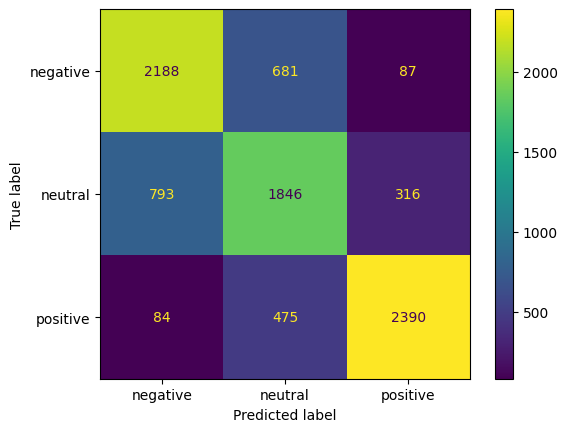

  0%|          | 0/8860 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      2934
     neutral       0.62      0.61      0.62      3012
    positive       0.83      0.84      0.84      2914

    accuracy                           0.72      8860
   macro avg       0.72      0.72      0.72      8860
weighted avg       0.72      0.72      0.72      8860



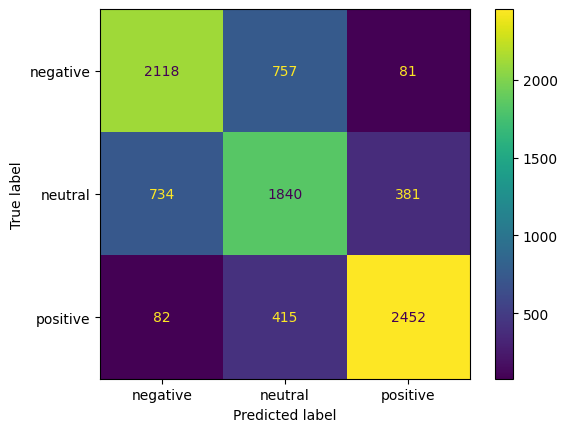

  0%|          | 0/8860 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.68      0.74      0.71      2715
     neutral       0.66      0.60      0.63      3257
    positive       0.82      0.84      0.83      2888

    accuracy                           0.72      8860
   macro avg       0.72      0.73      0.72      8860
weighted avg       0.72      0.72      0.72      8860



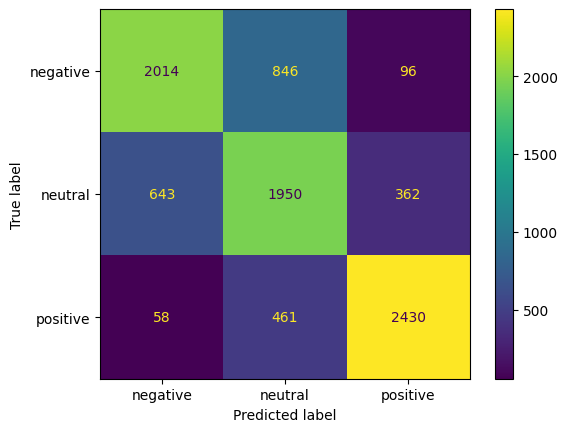

  0%|          | 0/8860 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.74      0.71      0.72      3076
     neutral       0.61      0.62      0.61      2899
    positive       0.82      0.84      0.83      2885

    accuracy                           0.72      8860
   macro avg       0.72      0.72      0.72      8860
weighted avg       0.72      0.72      0.72      8860



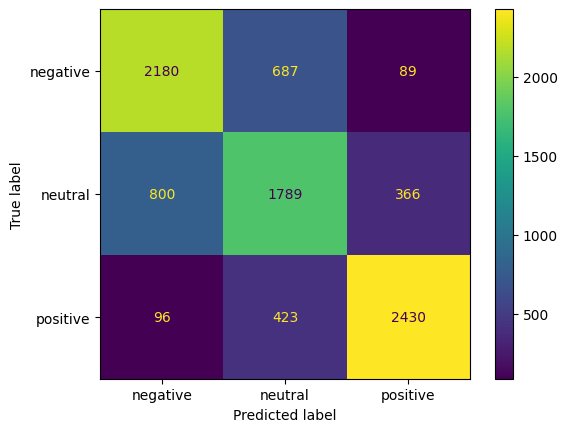

  0%|          | 0/8860 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    negative       0.72      0.72      0.72      2930
     neutral       0.65      0.60      0.63      3162
    positive       0.81      0.86      0.83      2768

    accuracy                           0.72      8860
   macro avg       0.72      0.73      0.72      8860
weighted avg       0.72      0.72      0.72      8860



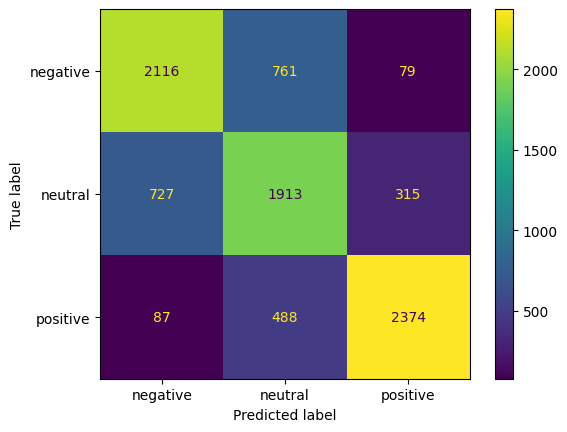

In [73]:
all_logits = dict()
all_predictions = dict()

for i in range (num_models):

    # инициализируем сохраненную модель, выгружаем состояние оптимизатора, переводим в состояние eval()
    bert_classifier, optimizer, scheduler = initialize_bert_model(epochs=5)
    checkpoint = torch.load(f'/kaggle/working/b_c_{i}.pt', map_location=torch.device('cpu'))
    bert_classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    bert_classifier.eval().to('cpu')

    # получаем логиты и прогнозы для каждой модели
    logits, predictions = bert_predictions(X_tt, y_tt, batch_size=1)
    all_logits[i] = logits
    all_predictions[i] = predictions

In [89]:
import numpy as np

In [95]:
np0 = torch.stack(all_logits[0]).detach().cpu().numpy()
np1 = torch.stack(all_logits[1]).detach().cpu().numpy()
np2 = torch.stack(all_logits[2]).detach().cpu().numpy()
np3 = torch.stack(all_logits[3]).detach().cpu().numpy()
np4 = torch.stack(all_logits[4]).detach().cpu().numpy()

features = np.hstack((np0, np1, np2, np3, np4))

In [96]:
target = y_tt


In [97]:
# Передаем логиты в метамодель
meta_model = LogisticRegression(solver='saga',penalty='l1', max_iter=500, random_state=42, class_weight='balanced')
meta_model.fit(features, target)

LogisticRegression(class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=42, solver='saga')

In [98]:
y_pred = meta_model.predict(features)
print(classification_report(y_pred,target, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.71      0.75      0.73      2818
     neutral       0.67      0.62      0.64      3222
    positive       0.82      0.86      0.84      2820

    accuracy                           0.74      8860
   macro avg       0.74      0.74      0.74      8860
weighted avg       0.73      0.74      0.73      8860



## SVM-классификация эмбеддингов с использованием библиотек sklearn

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weight = compute_class_weight(
    class_weight='balanced', classes=[0,1,2], y=labels
)

In [ ]:
clf = SVC(class_weight={0:class_weight[0], 1:class_weight[1], 2:class_weight[2]})

In [ ]:
clf.fit(np.array([tensor.numpy() for tensor in train_inputs]), train_labels)

In [ ]:
y_pred = clf.predict(np.array([tensor.numpy() for tensor in val_inputs])

In [ ]:
print(classification_report(y_pred, val_labels))

In [ ]:
cm = confusion_matrix(val_labels, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
disp.plot()
plt.show()

In [ ]:
# save the model to disk
filename = '/kaggle/working/svm_model.sav'
pickle.dump(clf, open(filename, 'wb'))

# Inference

In [ ]:
def predict(text, model=None, max_len=62, flag=False):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    if flag:
        print(f"This review is  {probs[0] * 100:.2f}% negative, {probs[1] * 100:.2f}% neutral & {probs[2] * 100:.2f}% positive.")
    return np.argmax(probs.detach().numpy())

## Инференс на моделях сверточных сетей

In [ ]:
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.1,
                                      dropout=0.5)

checkpoint = torch.load('/kaggle/working/cnn_rand.pt', map_location=torch.device('cpu'))
cnn_rand.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

cnn_rand.eval()

In [ ]:
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.1,
                                        dropout=0.5)
checkpoint = torch.load('/kaggle/working/cnn_static.pt', map_location=torch.device('cpu'))
cnn_static.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

cnn_static.eval()

In [ ]:
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=False,
                                        learning_rate=0.1,
                                        dropout=0.5)
checkpoint = torch.load('/kaggle/working/cnn_non_static.pt', map_location=torch.device('cpu'))
cnn_non_static.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

cnn_non_static.eval()

In [ ]:
model_list = []
model_list.append(("CNN-rand", cnn_rand_))
model_list.append(("CNN-static", cnn_static_))
model_list.append(("CNN-non-static", cnn_non_static_))

In [ ]:
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(cleaned_texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

In [ ]:
for name, model in model_list:
    # Сохраним индексы записей с ошибками
     predictions = []
    is_correct = []
    for text, label in zip(X_test, y_test):
        y_pred = predict(text, model= model.to("cpu"), max_len=62, flag=False)
        is_correct.append(y_pred==label)
        predictions.append(y_pred)
    # Столбец содержит признак совпадения/несовпадения факта и прогноза
    test_data[name] = is_correct
    test_data1[name] = predictions
    print(f'-----{name}--------')
    print(classification_report(np.array(predictions),y_test, target_names=['negative', 'neutral', 'positive']))
    cm = confusion_matrix(y_test, np.array(predictions), labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
    disp.plot()
    plt.show()
    print()

In [ ]:
test_data.to_csv('/kaggle/working/test_data.csv', index=False)

In [ ]:
test_data1.to_csv('/kaggle/working/test_data1.csv', index=False)

## inference для реккурентной сети

In [ ]:
rnn = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, rnn.parameters()), lr=0.0001)
checkpoint = torch.load('/kaggle/working/rnn.pt', map_location=torch.device('cpu'))
rnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
rnn.eval()

In [ ]:
predictions =[predict(text, model= rnn.to("cpu"), max_len=64, flag=False) for text in tqdm(X_test)]
is_correct = []
for y_pred, y_fact in zip(predictions, y_test):
    is_correct.append(y_pred==y_fact)
# Столбец содержит ошибочные записи для модели rnn
test_data['rnn'] = is_correct
test_data1['rnn'] = predictions
print(f'-----RNN--------')
print(classification_report(np.array(predictions), y_test, target_names=['negative', 'neutral', 'positive']))
cm = confusion_matrix(y_test, np.array(predictions), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
disp.plot()
plt.show()

In [ ]:
test_data.to_csv('/kaggle/working/test_data.csv', index=False)

In [ ]:
test_data1.to_csv('/kaggle/working/test_data1.csv', index=False)

## Инференс для bert_classifier

In [ ]:
bert_classifier, optimizer, scheduler = initialize_bert_model(epochs=5)
checkpoint = torch.load('/kaggle/working/bert_classifier.pt', map_location=torch.device('cpu'))
bert_classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
bert_classifier.eval().to('cpu')

In [72]:
def bert_predictions(X_test, y_test, batch_size):
  #преобразуем данные - раньше было batch_size=1
  test_inputs, test_masks = preprocessing_for_bert(X_test)
  test_labels = torch.tensor(y_test)
  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
  predictions = []
  all_logits = []
  # выполняем прогнозы
  for item in tqdm(test_dataloader):
      b_input_ids, b_attn_mask, b_labels = tuple(t.to('cpu') for t in item)
      with torch.no_grad():
          # Получение предсказаний модели
          logits = bert_classifier(b_input_ids, b_attn_mask)[0]

          # Получение индекса класса с наибольшей вероятностью
          y_pred = torch.argmax(logits, axis=-1).tolist()
      predictions.append(y_pred)
      all_logits.append(logits)
  # считаем метрики
  print(classification_report(predictions, y_test, target_names=['negative', 'neutral', 'positive']))
  cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['negative', 'neutral', 'positive'])
  disp.plot()
  plt.show()
  return all_logits, predictions

In [ ]:
len(X_test)

In [ ]:
#  Здесь важно, чтобы токенайзер был на короткие эмбеддинги
predictions = bert_predictions(X_test, y_test, batch_size=1)
is_correct = []
for y_pred, y_fact in zip(predictions, y_test):
  is_correct.append(y_pred==y_fact)
test_data['bert_classifier'] = is_correct
test_data1['bert_classifier'] = predictions

## Инференс для SVM - классификатора

## Инференс на датасете для оценки с использованием предобученных трансформеров



In [ ]:
from transformers import pipeline
hf_model = pipeline(model="seara/rubert-tiny2-russian-sentiment")

In [ ]:
# нужно уменьшить длину в токенах до максимальной 512.
# Т.к в пайплайне huggingfасе встроенный токенизатор, нужно обрезать тексты за пределами
truncated_texts = [' '.join(text.split()[:64]) for text in tqdm(X_test)]

In [ ]:
# Это словарь для перевода названий в метки классов
sent_dict ={'negative': 0, 'neutral':1, 'positive': 2}
predictions = [hf_model(text)[0]['label'] for text in tqdm(truncated_texts)]
predictions_ = [sent_dict[x] for x in predictions]

print(classification_report(np.array(predictions_),y_test, target_names=['negative', 'neutral', 'positive']))
cm = confusion_matrix(y_test, np.array(predictions_), labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['negative', 'neutral', 'positive'])
disp.plot()
plt.show()


Вывод: В работе для классификации отзывов покупателей были использованы следующие модели:
    
    - baselinе: TFiDF + Logistic Regression
    - Сверточная сеть:
        - Модель 1 - с случайной инициализацией эмбеддингов
        - Модель 2 - с использованием замороженных эмбеддингов compressed fasstext
        - Модель 3 - с использованием эмбеддингов compressed fasstext, обучаемых в процессе обучения модели
    - Модель 4 - Реккурентная сеть (bi-LSTM)
    - Модель 5 -предобученный трансформер с huggingface ( на базе архитектуры rubert)
Из-за ограничений по вычислительной мощности не удалось проверить работу моделей с эмбеддингами больших размеров ( использовались стандартные с размерностью 300), в трансформере - размерность 512.

Качество работы моделей проверялось на сбалансированном тестовом датасете, а также на инференсных данных ( несбалансированный датасет).

На тестовом датасете  наилучшие результаты показала Модель 1 - weighted accuracy=80% (73% baseline, 67% на трансформере, 77% - Модель2, 79% - Модель 3

на инференсных данных сравнение моделей производилось по f1-score по классу negatives. Лучшие результаты показала Модель 3 - f1_score=51% (30% baseline, 42% на трансформере, 43% - Модель 4, 45% - Модели 2 и 3)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-10)
    return sum_embeddings / sum_mask

In [ ]:
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruElectra-small")
model = AutoModel.from_pretrained("sberbank-ai/ruElectra-small")

In [ ]:
#Tokenize sentences
encoded_input = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=24, return_tensors='pt')
#Compute token embeddings

In [ ]:
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [ ]:
sentence_embeddings.shape

In [ ]:

# Store sentences & embeddings on disc
with open("sber_embeddings.pkl", "wb") as fOut:
    pickle.dump({"sentences": cleaned_texts, "embeddings": sentence_embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

# # Load sentences & embeddings from disc
# with open("/kaggle/input/diplom/sber_embeddings.pkl", "rb") as fIn:
#     stored_data = pickle.load(fIn)
#     stored_sentences = stored_data["sentences"]
#     stored_embeddings = stored_data["embeddings"]

## SVM - модель с использованием полученных эмбеддингов

In [ ]:
# Load sentences & embeddings from disc
with open("/kaggle/input/diplom/sber_embeddings.pkl", "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data["sentences"]
    stored_embeddings = stored_data["embeddings"]

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
class_weight = compute_class_weight(
    class_weight='balanced', classes=[0,1,2], y=cleaned_labels
)
class_weight

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    sentence_embeddings, cleaned_labels, test_size=0.2, random_state=42, stratify=cleaned_labels)

In [ ]:
# initialize the model and assign weights to each class
clf = SVC(class_weight={0:class_weight[0], 1:class_weight[1], 2:class_weight[2]})

In [ ]:
# train the model
clf.fit(X_train, y_train)

In [ ]:
# use the model to predict the testing instances
y_pred = clf.predict(np.array(X_val))
# generate the classification report
print(classification_report(y_test, y_val))

Реализация SVM-классификации эмбеддингов с использованием pytorch

In [ ]:
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, input):
        # Expect input to be shape (N, self.input_dim)
        output = self.linear(input) # Shape (N, 1)
        output = output.flatten() # Shape (N)
        return output 



In [ ]:
def HingeLoss(pred, truth):
    # Expect both of shape (N)
    loss_tensor = nn.ReLU()(1-pred*truth)
    return torch.mean(loss_tensor)

In [ ]:
model = SVM(input_dim=input_dim)
criterion = HingeLoss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
batch_size = 8
epochs = 100
learning_rate = 0.05
weight_decay = 1e-3

In [ ]:
train_dataloader, val_dataloader = \
data_loader(X_train, X_vals, y_train, y_val, batch_size=batch_size)

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print("="*50)
    running_loss = 0.0
    train_loader_n = len(train_dataloader)
    for i, data in enumerate(train_dataloader, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss is {round(running_loss/train_loader_n, 4)}.")

    eval_rloss = 0
    val_loader_n = len(val_dataloader)
    for i, data in enumerate(val_dataloader, 0):
        model.eval()

        inputs, labels = data

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)

        eval_rloss += loss.item()
    print(f"Epoch {epoch+1} eval loss is {round(eval_rloss/val_loader_n, 4)}.")

print('Finished Training')
print('Model parameters are')
print(model.linear.weight.data)
print(model.linear.bias.data)
torch.save(model.state_dict(), model_path)
print(f"Model saved in {model_path}.")

In [ ]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='YOUR PROJECT ID')